In [ ]:
## The goal of this notebook is to reproduce the results of the nonlinear backdoor 
## (from Vahid's paper) notebook (and corresponding python script)

## Module imports
import pandas as pd
import sys
sys.path.append("..")
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.causalpfn.causal_estimator import CausalEstimator
from src.causalpfn import ATEEstimator
from functools import reduce

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
## MAIN HYPERPARAMETER
N_DISC_VALUES = [2, 3]

## Main body
# Discretization function
def discretize_treatment(T: np.ndarray, N: int) -> np.ndarray:
    """Returns discretized version of T. Assumes range of T is [0, 1].

    Args:
        T (np.ndarray): The raw treatment data 
        N (int): The number of discretized treatment values to use

    Returns:
        np.ndarray: The discretized treatment data
    """
    dt = 1 / (N - 1)
    T_discrete = np.round(np.array(T, dtype=np.float32) / dt) * dt

    return T_discrete

# RMSE function
def calculate_rmse(y_pred, y_true):
    result = np.mean(np.power(y_pred - y_true, 2))
    result = np.sqrt(result)

    return result

In [ ]:
## Synthetic data generation

# Generate synthetic data, using the DGP from Vahid's paper - nonlinear backdoor
np.random.seed(42)
n, d = 2000, 1
X = np.random.normal(2, 1, size=(n, d)).astype(np.float32)
T = (0.1 * X[:, 0] ** 2 - X[:, 0] + np.random.normal(1, 2, size=n)).astype(np.float32)
T = T - T.min() # Rescale
T = T / T.max() # Rescale
Y = (0.5 * T ** 2 - T * X[:, 0] + np.random.normal(0, 2, size=n)).astype(np.float32)
def drf(t): return 0.5 * t ** 2 - 2 * t # true dose-response funcion

df = pd.concat([
    pd.DataFrame(data=X, columns=["x"]), 
    pd.DataFrame(data=T, columns=["T"]), 
    pd.DataFrame(data=Y, columns=["Y"])
    ], axis=1)

In [ ]:
list_of_epos = [] # [(N_DISC, epos)], epos = [(mu_t0, mu_t1), (mu_t1, mu_t2), ... ]
list_of_ates = [] # [(N_DISC, ates)], ates = [ATE(t0, t1), ATE(t1, t2), ...]

for N_DISC in N_DISC_VALUES:
    print(f"N_DISC: {N_DISC}")
    discrete_treatment_levels = np.linspace(0, 1, N_DISC)
    T_discrete = discretize_treatment(T, N_DISC)
    epos = []
    ates = []
    for i, t in enumerate(discrete_treatment_levels[:-1]):
        t0, t1 = discrete_treatment_levels[i], discrete_treatment_levels[i + 1]
        ids = (np.abs(T_discrete - t0) < 1e-4) | (np.abs(T_discrete - t1) < 1e-4)
        T_temp = np.where(np.abs(T_discrete[ids] - t0) < 1e-4, 0, 1).astype(np.float32)
        X_temp = X[ids].astype(np.float32)
        Y_temp = Y[ids].astype(np.float32)
        # to predict ate
        causalpfn_ate = ATEEstimator(
            device=device,
            verbose=True
        )
        causalpfn_ate.fit(X_temp, T_temp, Y_temp)
        ate = causalpfn_ate.estimate_ate()
        ates.append(ate)
        # to predict cepo
        X_context = X_temp 
        t_context = T_temp
        y_context = Y_temp
        X_query = X_temp 
        t_all_ones = np.ones(X_query.shape[0], dtype=X_query.dtype)
        t_all_zeros = np.zeros(X_query.shape[0], dtype=X_query.dtype)
        causalpfn_cepo = CausalEstimator(
            device=device,
            verbose=True
        )
        causalpfn_cepo.fit(X_temp, T_temp, Y_temp)
        mu_vals = causalpfn_cepo._predict_cepo(
            X_context=X_context,
            t_context=t_context,
            y_context=y_context,
            X_query=np.concatenate([X_query, X_query], axis=0),
            t_query=np.concatenate([t_all_zeros, t_all_ones], axis=0),
            temperature=causalpfn_cepo.prediction_temperature,
        )
        mu_0 = (mu_vals[: X_query.shape[0]]).mean()
        mu_1 = (mu_vals[X_query.shape[0] :]).mean()
        epos.append((mu_0, mu_1))
    list_of_epos.append((N_DISC, epos))
    list_of_ates.append((N_DISC, ates))


N_DISC: 2


Predicting CEPO: 100%|██████████| 4000/4000 [00:07<00:00, 500.74it/s]


N_DISC: 3


Predicting CEPO: 100%|██████████| 3624/3624 [00:07<00:00, 516.27it/s]


In [ ]:
# epos = [(mu_t0, mu_t1), (mu_t1, mu_t2), (mu_t2, mu_t3)]
# Take the first tuple whole, then just the second entry in the remaining tuples

In [ ]:
epos = list_of_epos[1][1] # epos we want to visualize
ates = list_of_ates[1][1] # ates we want to visualize
col_names = ["mu_0_est", "mu_0.5_est", "mu_1_est", "ATE from _predict_cepo", "ATE from estimate_ate"]
row_names = ["[0, 0.5]", "[0.5, 1]"]
df = pd.DataFrame("NA", index=row_names, columns=col_names) 
discrete_treatment_levels = [0, 0.5, 1]
intermediate_treatment_levels = discrete_treatment_levels[1:-1]
df.loc["[0, 0.5]", "mu_0_est"] = epos[0][0]
df.loc["[0.5, 1]", "mu_1_est"] = epos[-1][-1]
for i in range(0, len(intermediate_treatment_levels)):
    row_1 = f"[{discrete_treatment_levels[i]}, {discrete_treatment_levels[i + 1]}]"
    row_2 = f"[{discrete_treatment_levels[i + 1]}, {discrete_treatment_levels[i + 2]}]"
    col = f"mu_{intermediate_treatment_levels[i]}_est"
    df.loc[row_1, col] = epos[i][1]
    df.loc[row_2, col] = epos[i + 1][0]

for i in range(len(discrete_treatment_levels) - 1):
    left = df.loc[row_names[i], f"mu_{discrete_treatment_levels[i]}_est"]
    right = df.loc[row_names[i], f"mu_{discrete_treatment_levels[i + 1]}_est"]
    df.loc[row_names[i], "ATE from _predict_cepo"] = right - left
    df.loc[row_names[i], "ATE from estimate_ate"] = ates[i]

df

0


,mu_0_est,mu_0.5_est,mu_1_est,ATE from _predict_cepo,ATE from estimate_ate
"[0, 0.5]",-0.326206,-0.961495,NA,-0.635289,-0.635289
"[0.5, 1]",NA,-0.934088,-0.214735,0.719353,0.719353


In [ ]:
# Plot ate curve
plt.plot(discrete_treatment_levels, [0] + ates, 
         label="estimate_ates and enforce $Y_0 = 0$") # With Y_0 = 0 enforced
plt.plot(discrete_treatment_levels, [epos[0][0]] + ates, 
         label="estimate_ates and set Y_0 = mu_0$") # With Y_0 = mu_0_est

# True dose-response curve
plt.plot(np.linspace(0.0, 1.0, 100), drf(np.linspace(0.0, 1.0, 100)),
         label="True dose-response curve", linewidth=2, c='k', zorder=15)

plt.title("$E[Y_t]$ with _predict_cepo vs estimate_ate") # Note E[Y_t] = E[Y | do(T = t)]
plt.xlabel("Treatment dosage t")
plt.ylabel("Expected outcome Y")
plt.legend()

Error in callback <function _draw_all_if_interactive at 0x000001CCB72728E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [50]:
# To get a good RMSE estimate for all the predictions, need a large mesh
fine_mesh = np.linspace(0, 1, 100) # fixed, fine mesh
t_mesh = [np.linspace(0, 1, N_DISC) for N_DISC in N_DISC_VALUES] # to ensure all discrete treatment values are hit
t_mesh += [fine_mesh]
t_mesh = reduce(np.union1d, tuple(t_mesh))

# Get RMSE by evaluating on each of the t_mesh points
rmse_dict = dict()
y_true = drf(t_mesh)
for N_DISC, epos in list_of_epos:
    epos_to_plot = [epos[0][0], epos[0][1]] + [mu_1 for (mu_0, mu_1) in epos[1:]]
    y_pred = np.interp(t_mesh, np.linspace(0, 1, N_DISC), epos_to_plot)
    error = calculate_rmse(y_pred, y_true)
    rmse_dict[N_DISC] = np.round(error, 4)

# Create dataframe
df = pd.DataFrame.from_dict(rmse_dict, orient="index", columns=["RMSE"])
df

,RMSE
2,0.3888
3,0.5418


<Axes: title={'center': 'RMSE of different choices of N_DISC'}, xlabel='N_DISC', ylabel='RMSE'>

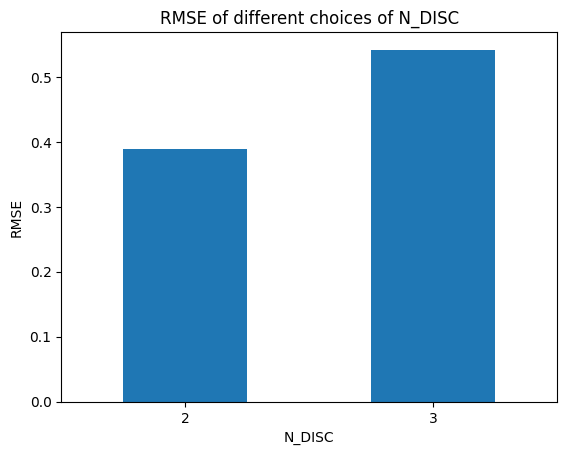

In [51]:
df.plot.bar(rot=0, title="RMSE of different choices of N_DISC", xlabel="N_DISC", ylabel="RMSE", legend=False)

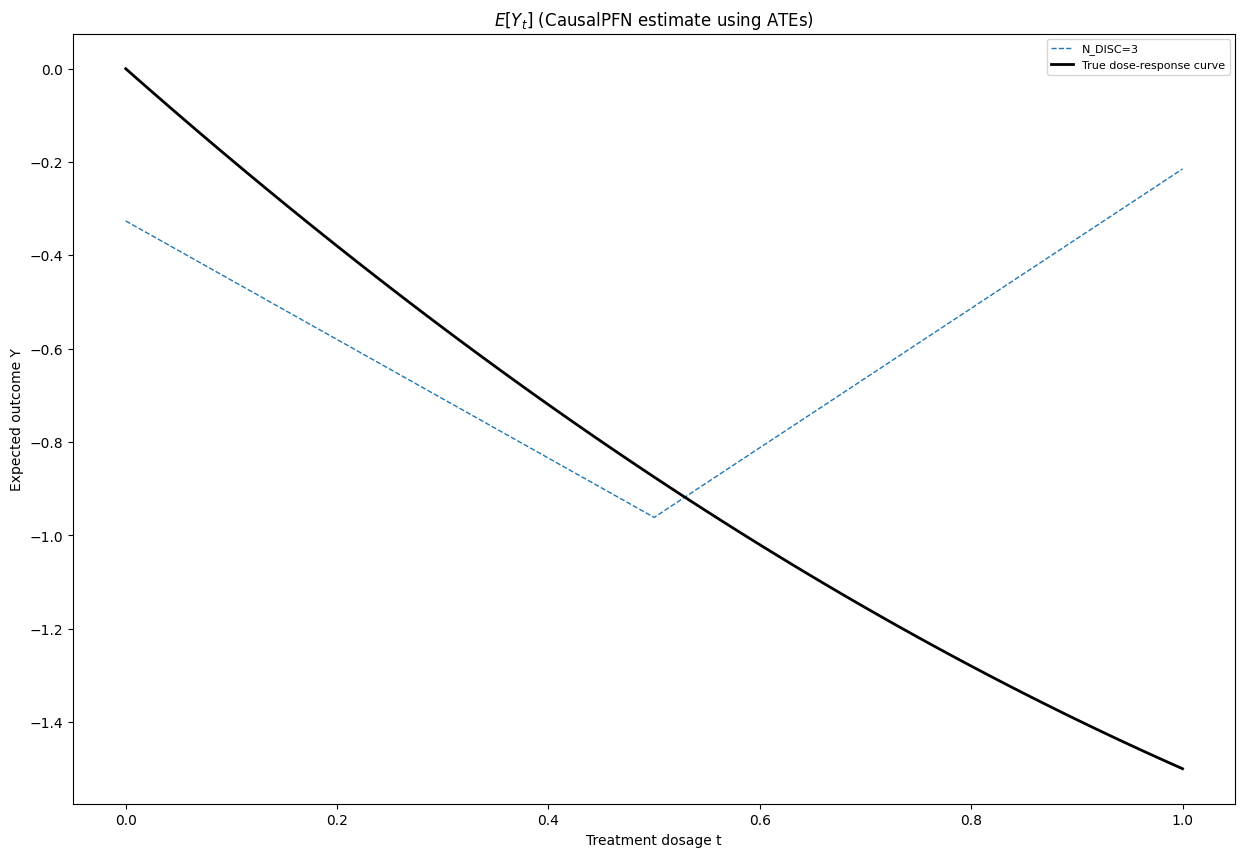

In [53]:
fig = plt.figure(figsize=(15, 10))

# Plot predictions

for N_DISC, epos in list_of_epos[1:2]:
    epos_to_plot = [epos[0][0], epos[0][1]] + [mu_1 for (mu_0, mu_1) in epos[1:]]
    if df.loc[N_DISC, "RMSE"] == df.min().values: # Emphasize best prediction
        plt.plot(np.linspace(0.0, 1.0, N_DISC), epos_to_plot, '-', linewidth=2,
                 label=f"N_DISC={N_DISC} (Best)", c="blue", zorder=14)
    else:
        plt.plot(np.linspace(0.0, 1.0, N_DISC), epos_to_plot, '--', linewidth=1,
                 label=f"N_DISC={N_DISC}")

# True dose-response curve
plt.plot(np.linspace(0.0, 1.0, 100), drf(np.linspace(0.0, 1.0, 100)),
         label="True dose-response curve", linewidth=2, c='k', zorder=15)

plt.title("$E[Y_t]$ (CausalPFN estimate using ATEs)") # Note E[Y_t] = E[Y | do(T = t)]
plt.xlabel("Treatment dosage t")
plt.ylabel("Expected outcome Y")

plt.legend(fontsize=8)
plt.show()